In [6]:
import sys
sys.path.append('../src')

from data.notes_loader import NotesLoader
import pandas as pd

# 1. Carregar ED stays (do pipeline completo)
edstays = pd.read_parquet('../data/processed/labeled_data.parquet')

print(f"ED stays carregados: {len(edstays):,}")
print(f"Admissions únicas: {edstays['hadm_id'].nunique():,}")

# 2. Extrair IDs relevantes
relevant_subjects = edstays['subject_id'].unique().tolist()
relevant_hadms = edstays['hadm_id'].unique().tolist()

print(f"\nFiltrando por:")
print(f"  - {len(relevant_subjects):,} pacientes")
print(f"  - {len(relevant_hadms):,} admissions")

# 3. Carregar notas COM timestamps
loader = NotesLoader(data_root='../data/raw/')

notes = loader.load_notes(
    categories=['discharge', 'radiology'],
    subject_ids=relevant_subjects,
    hadm_ids=relevant_hadms,
    chunksize=10000
)

# 4. VALIDAR timestamps
print("\n" + "="*60)
print("VALIDAÇÃO DE TIMESTAMPS")
print("="*60)

time_cols = ['charttime', 'chartdate', 'storetime']
for col in time_cols:
    if col in notes.columns:
        non_null = notes[col].notna().sum()
        pct = non_null / len(notes) * 100
        print(f"✓ {col:15s}: {non_null:8,} ({pct:5.1f}%) não-nulos")
        
        if non_null > 0:
            print(f"    Range: {notes[col].min()} → {notes[col].max()}")
    else:
        print(f"✗ {col:15s}: AUSENTE")

# 5. Se timestamps OK, aplicar filtro temporal
if 'charttime' in notes.columns or 'chartdate' in notes.columns:
    print("\n" + "="*60)
    print("APLICANDO FILTRO TEMPORAL")
    print("="*60)
    
    notes_temporal = loader.filter_temporal(
        notes, 
        edstays,
        time_buffer_hours=0  # Rigoroso: apenas ANTES do discharge
    )
    
    print(f"\nResultado:")
    print(f"  - Antes:  {len(notes):,} notas")
    print(f"  - Depois: {len(notes_temporal):,} notas")
    print(f"  - Retidas: {len(notes_temporal)/len(notes)*100:.1f}%")
    
    # 6. Salvar dataset temporal
    output_path = '../data/processed/clinical_notes_temporal.parquet'
    notes_temporal.to_parquet(output_path, index=False)
    print(f"\n✅ Salvo em: {output_path}")
    
else:
    print("\n⚠️ PROBLEMA: Nenhum timestamp disponível!")
    print("   Arquivos MIMIC-IV-Note podem estar sem essas colunas.")
    print("   Verifique estrutura com: loader.inspect_file_structure('discharge')")

INFO:data.notes_loader:✓ Categorias disponíveis: discharge, radiology
INFO:data.notes_loader:📖 Carregando discharge notes em chunks de 10,000...
INFO:data.notes_loader:   Carregando colunas: ['subject_id', 'hadm_id', 'charttime', 'storetime', 'text', 'note_id', 'note_type', 'note_seq']
INFO:data.notes_loader:   Parseando datas: ['charttime', 'storetime']


ED stays carregados: 189,158
Admissions únicas: 185,984

Filtrando por:
  - 99,346 pacientes
  - 185,984 admissions


INFO:data.notes_loader:   Processados 10 chunks, 21,744 notas mantidas
INFO:data.notes_loader:   Processados 20 chunks, 43,674 notas mantidas
INFO:data.notes_loader:   Processados 30 chunks, 65,552 notas mantidas
INFO:data.notes_loader:✓ discharge: 72,544 notas carregadas
INFO:data.notes_loader:📖 Carregando radiology notes em chunks de 10,000...
INFO:data.notes_loader:   Carregando colunas: ['subject_id', 'hadm_id', 'charttime', 'storetime', 'text', 'note_id', 'note_type', 'note_seq']
INFO:data.notes_loader:   Parseando datas: ['charttime', 'storetime']
INFO:data.notes_loader:   Processados 10 chunks, 10,302 notas mantidas
INFO:data.notes_loader:   Processados 20 chunks, 20,758 notas mantidas
INFO:data.notes_loader:   Processados 30 chunks, 31,974 notas mantidas
INFO:data.notes_loader:   Processados 40 chunks, 41,738 notas mantidas
INFO:data.notes_loader:   Processados 50 chunks, 52,557 notas mantidas
INFO:data.notes_loader:   Processados 60 chunks, 63,327 notas mantidas
INFO:data.note


VALIDAÇÃO DE TIMESTAMPS
✓ charttime      :  315,202 (100.0%) não-nulos
    Range: 2110-01-11 05:42:00 → 2212-02-01 00:00:00
✗ chartdate      : AUSENTE
✓ storetime      :  315,202 (100.0%) não-nulos
    Range: 2110-01-11 07:01:00 → 2212-02-02 21:33:00

APLICANDO FILTRO TEMPORAL


INFO:data.notes_loader:  - Notas após merge com ED stays: 312,555
INFO:data.notes_loader:  - Notas com timestamps válidos: 312,555
INFO:data.notes_loader:✓ Filtro temporal: 315,202 → 98,147 notas (31.1% mantidas)



Resultado:
  - Antes:  315,202 notas
  - Depois: 98,147 notas
  - Retidas: 31.1%

✅ Salvo em: ../data/processed/clinical_notes_temporal.parquet


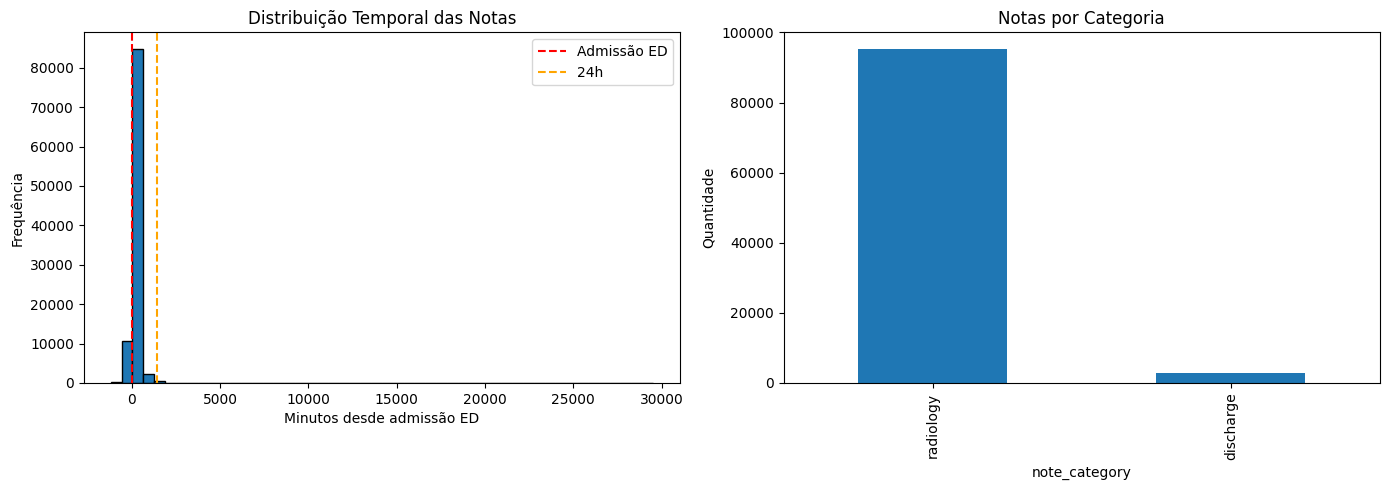


ESTATÍSTICAS DE TAMANHO
                 count         mean          std    min     25%     50%  \
note_category                                                             
discharge       2872.0  8400.534471  2899.245171  570.0  6374.5  8233.0   
radiology      95275.0  1261.477533  1058.340435   29.0   570.0   848.0   

                   75%      max  
note_category                    
discharge      10044.5  42913.0  
radiology       1515.0  11805.0  

📊 Overlap com desfechos:
  - Notas em pacientes críticos: 13,093
  - Notas em ED stay longo: 5,894

🔤 Top 30 palavras:
  there               : 3,047
  with                : 2,764
  right               : 1,773
  left                : 1,550
  normal              : 1,459
  chest               : 1,315
  findings            : 1,136
  evidence            : 1,029
  impression          :   957
  acute               :   930
  comparison          :   928
  were                :   918
  contrast            :   915
  technique           :   84

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

notes_temporal = pd.read_parquet('../data/processed/clinical_notes_temporal.parquet')

# --- Análise 1: Distribuição Temporal ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tempo desde admissão
axes[0].hist(notes_temporal['time_from_admission_min'], bins=50, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', label='Admissão ED')
axes[0].axvline(24*60, color='orange', linestyle='--', label='24h')
axes[0].set_xlabel('Minutos desde admissão ED')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição Temporal das Notas')
axes[0].legend()

os.makedirs('../reports', exist_ok=True)
# Por categoria
notes_temporal['note_category'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Notas por Categoria')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.savefig('../reports/notes_temporal_distribution.png', dpi=300)
plt.show()

# --- Análise 2: Tamanho das Notas ---
print("\n" + "="*60)
print("ESTATÍSTICAS DE TAMANHO")
print("="*60)

notes_temporal['text_length'] = notes_temporal['text'].str.len()

by_category = notes_temporal.groupby('note_category')['text_length'].describe()
print(by_category)

# --- Análise 3: Overlap com Desfechos ---
merged = notes_temporal.merge(
    edstays[['subject_id', 'hadm_id', 'critical_outcome', 'lengthened_ed_stay']],
    on=['subject_id', 'hadm_id'],
    how='inner'
)

print(f"\n📊 Overlap com desfechos:")
print(f"  - Notas em pacientes críticos: {merged[merged['critical_outcome']==1].shape[0]:,}")
print(f"  - Notas em ED stay longo: {merged[merged['lengthened_ed_stay']==1].shape[0]:,}")

# --- Análise 4: Palavras-Chave ---
from collections import Counter
import re

def extract_keywords(text):
    words = re.findall(r'\b[a-z]{4,}\b', text.lower())
    return words

# Sample de 1000 notas para análise rápida
sample_texts = notes_temporal.sample(min(1000, len(notes_temporal)))['text']
all_words = []
for text in sample_texts:
    all_words.extend(extract_keywords(str(text)))

top_words = Counter(all_words).most_common(30)
print("\n🔤 Top 30 palavras:")
for word, count in top_words:
    print(f"  {word:20s}: {count:5,}")

INFO:data.notes_loader:⏱️ Aplicando filtro temporal nas notas...
INFO:data.notes_loader:  - Notas com hadm_id válido: 315,202
INFO:data.notes_loader:  - Notas após merge com ED stays: 312,555
INFO:data.notes_loader:  - Notas com timestamps válidos: 312,555
INFO:data.notes_loader:✓ Filtro temporal: 315,202 → 98,147 notas (31.1% mantidas)
INFO:data.notes_loader:⏱️ Aplicando filtro temporal nas notas...
INFO:data.notes_loader:  - Notas com hadm_id válido: 315,202
INFO:data.notes_loader:  - Notas após merge com ED stays: 312,555
INFO:data.notes_loader:  - Notas com timestamps válidos: 312,555
INFO:data.notes_loader:✓ Filtro temporal: 315,202 → 103,814 notas (32.9% mantidas)
INFO:data.notes_loader:⏱️ Aplicando filtro temporal nas notas...
INFO:data.notes_loader:  - Notas com hadm_id válido: 315,202
INFO:data.notes_loader:  - Notas após merge com ED stays: 312,555
INFO:data.notes_loader:  - Notas com timestamps válidos: 312,555
INFO:data.notes_loader:✓ Filtro temporal: 315,202 → 114,289 nota

   buffer_hours  notes_retained  retention_rate
0             0           98147       31.137810
1             2          103814       32.935705
2             6          114289       36.258970
3            12          127628       40.490860
4            24          152395       48.348361


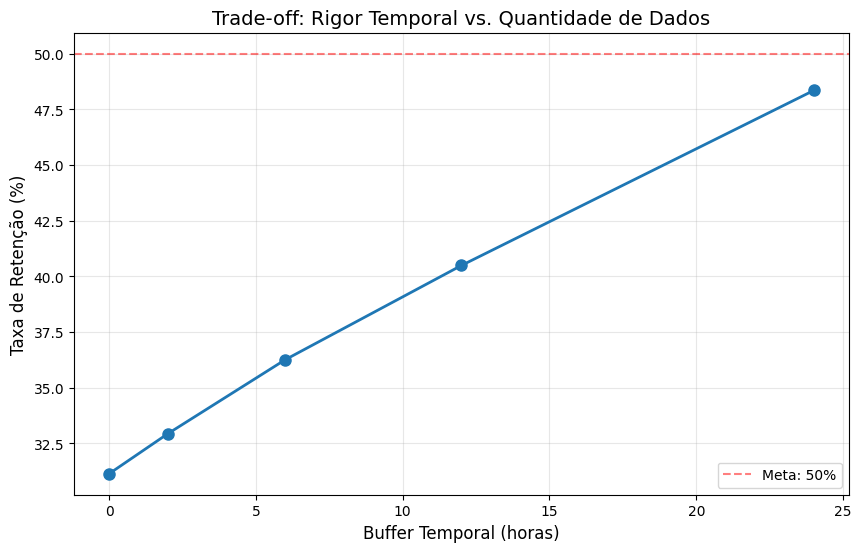

In [10]:
# Testar diferentes buffers
buffers_to_test = [0, 2, 6, 12, 24]  # horas

results = []
for buffer in buffers_to_test:
    notes_filtered = loader.filter_temporal(
        notes, edstays, time_buffer_hours=buffer
    )
    
    results.append({
        'buffer_hours': buffer,
        'notes_retained': len(notes_filtered),
        'retention_rate': len(notes_filtered) / len(notes) * 100
    })

results_df = pd.DataFrame(results)
print(results_df)

# Visualizar trade-off
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['buffer_hours'], results_df['retention_rate'], 
         marker='o', linewidth=2, markersize=8)
plt.axhline(50, color='red', linestyle='--', alpha=0.5, label='Meta: 50%')
plt.xlabel('Buffer Temporal (horas)', fontsize=12)
plt.ylabel('Taxa de Retenção (%)', fontsize=12)
plt.title('Trade-off: Rigor Temporal vs. Quantidade de Dados', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('../reports/temporal_buffer_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Ver impacto do filtro por categoria
notes['category'] = notes['note_category']

retention_by_category = notes.groupby('category').apply(
    lambda x: pd.Series({
        'total': len(x),
        'retained': len(loader.filter_temporal(x, edstays, time_buffer_hours=0)),
        'retention_rate': len(loader.filter_temporal(x, edstays, time_buffer_hours=0)) / len(x) * 100
    })
)

print("\n📊 Retenção por Categoria:")
print(retention_by_category)

INFO:data.notes_loader:⏱️ Aplicando filtro temporal nas notas...
INFO:data.notes_loader:  - Notas com hadm_id válido: 72,544
INFO:data.notes_loader:  - Notas após merge com ED stays: 71,862
INFO:data.notes_loader:  - Notas com timestamps válidos: 71,862
INFO:data.notes_loader:✓ Filtro temporal: 72,544 → 2,872 notas (4.0% mantidas)
INFO:data.notes_loader:⏱️ Aplicando filtro temporal nas notas...
INFO:data.notes_loader:  - Notas com hadm_id válido: 72,544
INFO:data.notes_loader:  - Notas após merge com ED stays: 71,862
INFO:data.notes_loader:  - Notas com timestamps válidos: 71,862
INFO:data.notes_loader:✓ Filtro temporal: 72,544 → 2,872 notas (4.0% mantidas)
INFO:data.notes_loader:⏱️ Aplicando filtro temporal nas notas...
INFO:data.notes_loader:  - Notas com hadm_id válido: 242,658
INFO:data.notes_loader:  - Notas após merge com ED stays: 240,693
INFO:data.notes_loader:  - Notas com timestamps válidos: 240,693
INFO:data.notes_loader:✓ Filtro temporal: 242,658 → 95,275 notas (39.3% manti


📊 Retenção por Categoria:
              total  retained  retention_rate
category                                     
discharge   72544.0    2872.0        3.958977
radiology  242658.0   95275.0       39.263078


In [13]:
# Merge com labels
notes_with_outcomes = notes_temporal.merge(
    edstays[['subject_id', 'hadm_id', 'critical_outcome', 'lengthened_ed_stay']],
    on=['subject_id', 'hadm_id'],
    how='inner'
)

print("\n🎯 Cobertura de Texto por Desfecho:")
print("\nCritical Outcome:")
print(notes_with_outcomes.groupby('critical_outcome').size())

print("\nLengthened ED Stay:")
print(notes_with_outcomes.groupby('lengthened_ed_stay').size())

# Verificar se pacientes críticos têm MAIS notas
avg_notes_critical = notes_with_outcomes.groupby(
    ['subject_id', 'hadm_id', 'critical_outcome']
).size().reset_index(name='n_notes')

print("\nMédia de notas por paciente:")
print(avg_notes_critical.groupby('critical_outcome')['n_notes'].describe())


🎯 Cobertura de Texto por Desfecho:

Critical Outcome:
critical_outcome
0    85376
1    13093
dtype: int64

Lengthened ED Stay:
lengthened_ed_stay
0    92575
1     5894
dtype: int64

Média de notas por paciente:
                    count      mean       std  min  25%  50%  75%   max
critical_outcome                                                       
0                 52695.0  1.620192  1.002450  1.0  1.0  1.0  2.0  26.0
1                  7332.0  1.785734  1.116974  1.0  1.0  1.0  2.0  18.0


In [14]:
def filter_temporal_hybrid(notes, edstays):
    """
    Radiology: buffer 0h (mais confiável)
    Discharge: buffer 12h (ainda útil)
    """
    
    rad_notes = notes[notes['note_category'] == 'radiology']
    dis_notes = notes[notes['note_category'] == 'discharge']
    
    rad_filtered = loader.filter_temporal(rad_notes, edstays, time_buffer_hours=0)
    dis_filtered = loader.filter_temporal(dis_notes, edstays, time_buffer_hours=12)
    
    return pd.concat([rad_filtered, dis_filtered], ignore_index=True)

notes_hybrid = filter_temporal_hybrid(notes, edstays)

INFO:data.notes_loader:⏱️ Aplicando filtro temporal nas notas...
INFO:data.notes_loader:  - Notas com hadm_id válido: 242,658
INFO:data.notes_loader:  - Notas após merge com ED stays: 240,693
INFO:data.notes_loader:  - Notas com timestamps válidos: 240,693
INFO:data.notes_loader:✓ Filtro temporal: 242,658 → 95,275 notas (39.3% mantidas)
INFO:data.notes_loader:⏱️ Aplicando filtro temporal nas notas...
INFO:data.notes_loader:  - Notas com hadm_id válido: 72,544
INFO:data.notes_loader:  - Notas após merge com ED stays: 71,862
INFO:data.notes_loader:  - Notas com timestamps válidos: 71,862
INFO:data.notes_loader:✓ Filtro temporal: 72,544 → 9,690 notas (13.4% mantidas)
